# **Ejercicio: clasificar en female / male caras en gris**

La base de datos usada es un subconjunto de la base de datos
"Labeled Faces in the Wild" ("LFW"):

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz

  http://vis-www.cs.umass.edu/lfw/

La separación en carpetas "female" / "male" se ha realizado usando
un código basado en:
https://github.com/Pletron/LFWgender

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import os
from PIL import Image

In [2]:
COLAB = False

Si se desea ejecutar en local:

- Descargar el dataset de: https://drive.google.com/file/d/1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei

- Poner variable COLAB a False

In [3]:
!ls -la

total 822512
drwxrwxr-x  6 tomas tomas      4096 Jan 11 13:44 .
drwxrwxr-x 10 tomas tomas      4096 Jan 11 12:57 ..
-rw-rw-r--  1 tomas tomas    100057 Jan 11 13:22 best_model.keras
-rw-r--r--  1 tomas tomas      3247 Jan 11 13:18 caras_aux.py
-rw-rw-r--  1 tomas tomas      1859 Jan 11 13:18 caras_aux.py.zip
-rw-rw-r--  1 tomas tomas    463258 Dec 23 14:52 color-base.ipynb
-rw-rw-r--  1 tomas tomas   4625014 Jan 10 13:39 color-cnn.ipynb
-rw-rw-r--  1 tomas tomas     34272 Jan 10 01:21 color-cnntl.ipynb
-rw-r--r--  1 tomas tomas      3237 Jan 11 13:18 funciones_auxiliares.py
-rw-rw-r--  1 tomas tomas      1788 Jan 11 13:18 funciones_auxiliares.py.zip
drwxr-xr-x  4 tomas tomas      4096 Nov 11  2019 gender_color
-rw-rw-r--  1 tomas tomas  41914348 Mar 11  2022 gender_color.zip
-rw-rw-r--  1 tomas tomas    435643 Jan 11 13:44 gris-base.ipynb
drwxrwxr-x  2 tomas tomas      4096 Jan 11 12:45 .ipynb_checkpoints
-rw-r--r--  1 tomas tomas 768229376 Jan 11 13:44 .jupyter_ystore.db
drwxrwxr-x  3

### Descarga de datos

In [4]:
if COLAB:
    aux = "'https://drive.usercontent.google.com/download?id=1kD_GKuU2doz3TSNVi45_BbwvDZ2KmEei&export=download&confirm=t&uuid=56f4f47a-291b-4ef9-895f-8886caf14b78'"
    !wget $aux -O ./gender.zip
    !unzip -qq ./gender.zip

In [5]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1jifedd49sgZI2ZA6722h9R-mRh2Ciqzp',
                                        dest_path='./caras_aux.py.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1w6rSNy0mDds1cDNBtbL9U1bkF4PiGCnK',
                                        dest_path='./funciones_auxiliares.py.zip', unzip=True)

## **Funciones auxiliares**

In [4]:
from IPython.display import SVG
from keras.utils import model_to_dot

def display_model(model):
    if COLAB:
        display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
    else:
        display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

2025-01-11 13:44:48.647879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 13:44:48.655403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736599488.663374   24656 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736599488.665756   24656 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 13:44:48.674418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss,
                          figsize=(10,4)):
    best_i = np.argmax(val_acc)
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [6]:
!ls -la

total 822520
drwxrwxr-x  6 tomas tomas      4096 Jan 11 13:44 .
drwxrwxr-x 10 tomas tomas      4096 Jan 11 12:57 ..
-rw-rw-r--  1 tomas tomas    100057 Jan 11 13:22 best_model.keras
-rw-r--r--  1 tomas tomas      3247 Jan 11 13:18 caras_aux.py
-rw-rw-r--  1 tomas tomas      1859 Jan 11 13:18 caras_aux.py.zip
-rw-rw-r--  1 tomas tomas    463258 Dec 23 14:52 color-base.ipynb
-rw-rw-r--  1 tomas tomas   4625014 Jan 10 13:39 color-cnn.ipynb
-rw-rw-r--  1 tomas tomas     34272 Jan 10 01:21 color-cnntl.ipynb
-rw-r--r--  1 tomas tomas      3237 Jan 11 13:18 funciones_auxiliares.py
-rw-rw-r--  1 tomas tomas      1788 Jan 11 13:18 funciones_auxiliares.py.zip
drwxr-xr-x  4 tomas tomas      4096 Nov 11  2019 gender_color
-rw-rw-r--  1 tomas tomas  41914348 Mar 11  2022 gender_color.zip
-rw-rw-r--  1 tomas tomas    436644 Jan 11 13:44 gris-base.ipynb
drwxrwxr-x  2 tomas tomas      4096 Jan 11 12:45 .ipynb_checkpoints
-rw-r--r--  1 tomas tomas 768237568 Jan 11 13:44 .jupyter_ystore.db
drwxrwxr-x  3

## **Exploración de datos**


Estadísticas básicas de la base de datos leída:
  # clases: 2
  # patrones: 2000
  # atributos (features): 625

Algunas imágenes de la clase "female":


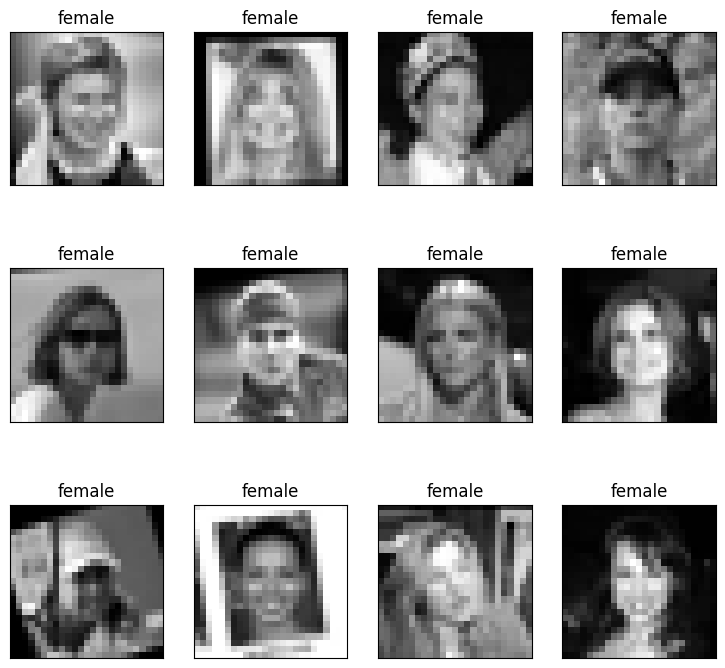


Algunas imágenes de la clase "male":


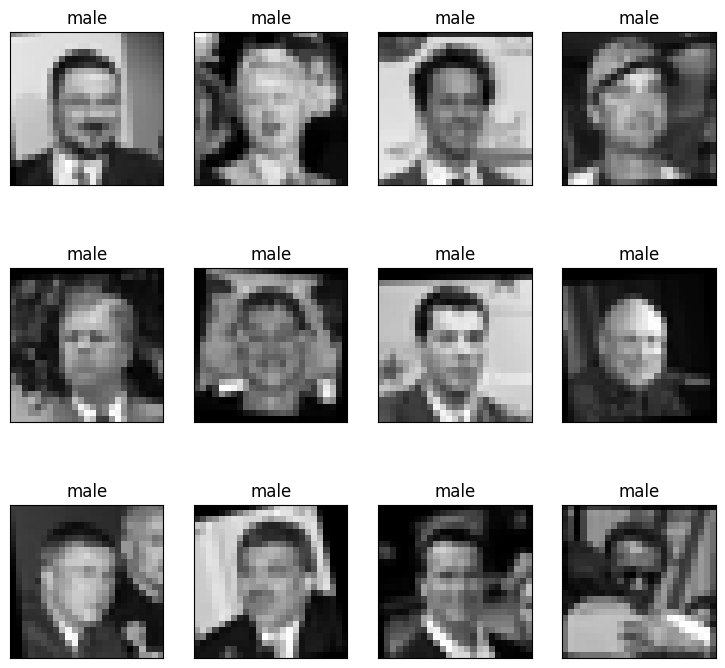

(3, 4)

In [9]:
from caras_aux import loadImages, plot_gallery

# cargo las imágenes y preparo los datos que se van a usar
factor = 0.1 # factor de resolución de las imágenes, debe ser
           # >0 y <=1 (en cuyo caso la resolución es la original, 250x250)
X_clase0, height, width = loadImages('./gender/female',
                                     factor=factor, nimages=1000)
X_clase1, height, width = loadImages('./gender/male',
                                     factor=factor, nimages=1000)
X = np.concatenate((X_clase0, X_clase1))
n_samples, n_features = X.shape

target_names = np.array(['female', 'male'])
n_classes = len(target_names)
N0 = len(X_clase0); N1 = len(X_clase1)
y = N0*[0] + N1*[1]
y = np.array(y)

print('\nEstadísticas básicas de la base de datos leída:')
print('  # clases: %d' % n_classes)
print('  # patrones: %d' % n_samples)
print('  # atributos (features): %d' % n_features)

print('\nAlgunas imágenes de la clase "female":')
plot_gallery(X_clase0[:12].reshape((12, height, width)),
             12*['female'], cmap=plt.cm.gray)
print('\nAlgunas imágenes de la clase "male":')
plot_gallery(X_clase1[:12].reshape((12, height, width)),
             12*['male'], cmap=plt.cm.gray)

In [10]:
print(np.shape(X)); print(np.shape(y)); print(X)

(2000, 625)
(2000,)
[[ 94. 110. 127. ...  95. 163. 162.]
 [  0.   0.   0. ...  51.  29.   0.]
 [ 10.   9.  10. ...   3.   5.   4.]
 ...
 [ 18.  21.  18. ...  22.  65. 176.]
 [  0.   0.   0. ...  37.  23.  14.]
 [  2.  20.  24. ... 142. 150. 113.]]


In [11]:
X.min(), X.max()

(np.float64(0.0), np.float64(255.0))

### Normalización de datos

In [12]:
X /= 255 #  equivalente a: X = X / 255

In [13]:
X.min(), X.max()

(np.float64(0.0), np.float64(1.0))

Ahora seguimos entendiendo la estructura de los datos:

In [14]:
y.shape

(2000,)

In [15]:
np.unique(y)

array([0, 1])

In [16]:
X.shape

(2000, 625)

In [17]:
np.sqrt(X.shape[1]) # lado de la imagen

np.float64(25.0)

### **Partición training-test**

In [18]:
from sklearn.model_selection import train_test_split

# divido en conjuntos de training y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=200,
                                                    random_state=42,
                                                    stratify=y)

# Stratify lo que hace es:
# 1. Separa los conjuntos por clase (conjunto 0: clase 0, conjunto 1: clase 1)
# 3. Separa cada uno de esos conjuntos en training y test:
#    - Conjunto0_train
#    - Conjunto0_test
#    - Conjunto1_train
#    - Conjunto1_test
#
# 4. Los fusiona:
#    - training = Conjunto0_train + Conjunto1_train
#    - test     = Conjunto0_test  + Conjunto1_test

In [19]:
# probabilidad de clase "male" en dataset total:
(y==1).mean()

np.float64(0.5)

In [20]:
# probabilidad de clase "male" en training y en test:
print((y_train==1).mean(), (y_test==1).mean())

0.5 0.5


Parto el conjunto de training en tr (training final) y validación:

In [21]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size=0.3,
                                            random_state=1,
                                            stratify=y_train)

Finalmente tengo los siguientes conjuntos:

- **X_tr:** conjunto con el que entreno la red
- **X_val:** conjunto con el que monitorizo la red mientras se entrena
- **X_test:** conjunto de test final

 Chequeo de las dimensiones de estos conjuntos:

In [22]:
X_tr.shape, y_tr.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1260, 625), (1260,), (540, 625), (540,), (200, 625), (200,))

Parece que están bien:

- La primera dimensión de X_tr e y_tr es igual
- La primera de X_val e y_val también
- La primera de X_test e y_test también
- La segunda dimensión de X_tr, X_val, X_test es 5625 (número total de píxels)

### **Estadísticas de las clases**

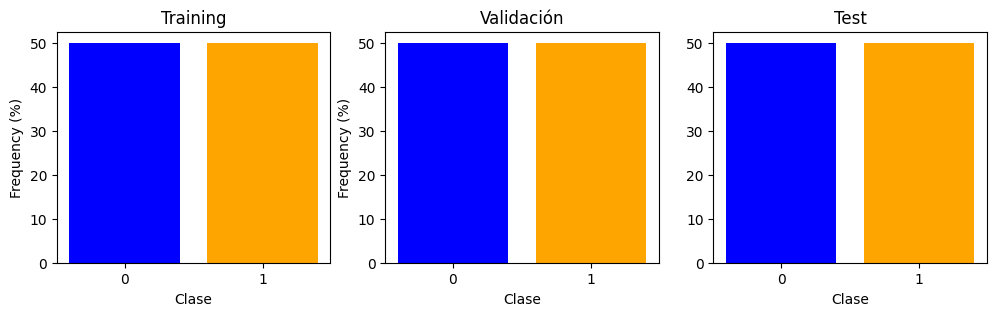

- Priori de la clase 0 en training: 0.500
- Priori de la clase 1 en training: 0.500
- Clase mayoritaria en training: 0

- Priori de la clase 0 en test: 0.500
- Priori de la clase 1 en test: 0.500
- Score de la clasificacion por mayoria en test: 0.500


In [23]:
from caras_aux import report_base_error

plt.figure(figsize=(12,3))
ax = plt.subplot(1,3,1)
clases, counts = np.unique(y_tr, return_counts=True)
plt.bar(clases, 100*counts/len(y_tr), color=["blue", "orange"])
plt.title('Training'); plt.xlabel('Clase'); plt.ylabel('Frequency (%)'); ax.set_xticks(clases)

ax = plt.subplot(1,3,2)
clases, counts = np.unique(y_val, return_counts=True)
plt.bar(clases, 100*counts/len(y_val), color=["blue", "orange"])
plt.title('Validación'); plt.xlabel('Clase'); plt.ylabel('Frequency (%)'); ax.set_xticks(clases)

ax = plt.subplot(1,3,3)
none, counts = np.unique(y_test, return_counts=True)
plt.bar(clases, 100*counts/len(y_test), color=["blue", "orange"])
plt.title('Test'); plt.xlabel('Clase'); ax.set_xticks(clases); plt.show()

report_base_error(X_tr, y_tr, X_test, y_test)

## **Modelo de referencia**

In [24]:
# Regresión logística:

from sklearn.linear_model import LogisticRegression
model0 = LogisticRegression(max_iter=1000, C=0.1) # C: factor de regularización. Cuanto más bajo, más "poda" (al revés que en Keras)
model0.fit(X_tr, y_tr)

LogisticRegression(C=0.1, max_iter=1000)

Scores en training, validación y test:

In [25]:
model0.score(X_tr, y_tr), model0.score(X_val, y_val), model0.score(X_test, y_test)
model0.score(X_tr, y_tr), model0.score(X_val, y_val), model0.score(X_test, y_test)

(0.8388888888888889, 0.7092592592592593, 0.74)

In [26]:
probs_test = model0.predict_proba(X_test)
probs_test[:5]

array([[0.8427694 , 0.1572306 ],
       [0.6375743 , 0.3624257 ],
       [0.10221432, 0.89778568],
       [0.50367547, 0.49632453],
       [0.29887079, 0.70112921]])

In [27]:
probs_test_male = probs_test[:,1] # segunda columna

In [28]:
from funciones_auxiliares import analisis_roc, plot_confusion_matrix

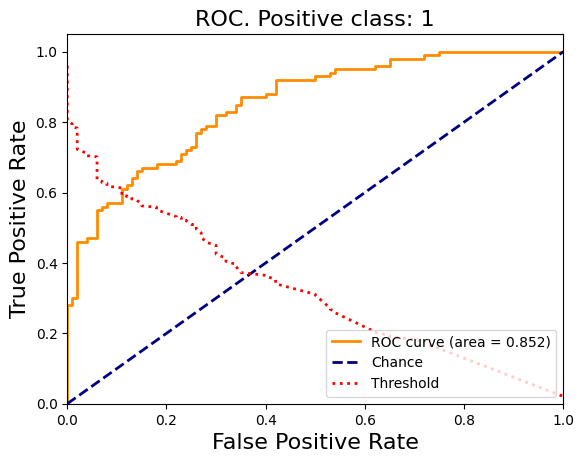

In [29]:
analisis_roc(y=y_test, positive_class_scores=probs_test_male, POSITIVE_CLASS=1)

In [30]:
# clases predichas en test:

predicciones_test = model0.predict(X_test)
predicciones_test[:5]

array([0, 0, 1, 0, 1])

Confusion matrix, without normalization
[[74 26]
 [26 74]]


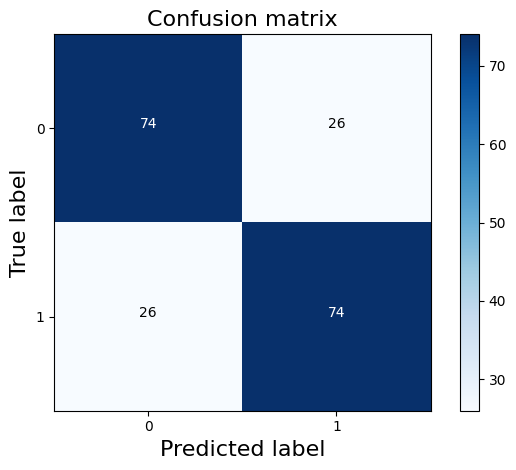

In [31]:
plot_confusion_matrix(y=y_test, y_pred=predicciones_test)

## **Implementación en Keras de un modelo que clasifique una cara en gris en female / male**

In [32]:
X.shape

(2000, 625)

In [33]:
# Definir modelo con 1 neurona de salida

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import L1, L2, L1L2
from keras.optimizers import Adam

model = Sequential()
model.add(Dropout(rate=0.2, input_shape=(X_tr.shape[1],)))
# Loss: entropía + 0.002*(|w0| + |w1| + ... en capa densa 1) + 0.01*(|w0|^2 + |w1|^2 + ... en capa densa 2)
model.add(Dense(5, activation='relu', # "primera capa densa"
                #input_shape=(X_tr.shape[1],),
                #kernel_regularizer=L1(0.002)
                ))
#model.add(Dense(5, activation='relu',
#                kernel_regularizer=L2(0.01)
#                ))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer=Adam(0.0001),
              #optimizer="adam",
              metrics=["accuracy"])

/home/tomas/venv/lib/python3.12/site-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1734961390.494387   23586 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5713 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 625)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         3,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,136 (12.25 KB)

 Trainable params: 3,136 (12.25 KB)

 Non-trainable params: 0 (0.00 B)

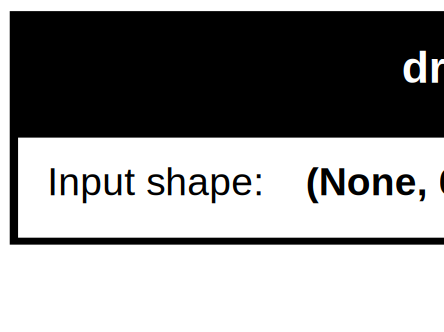

In [35]:
display_model(model)

## **Entrenamiento del modelo**

In [36]:
from keras.callbacks import ModelCheckpoint

serie_tr_acc = []
serie_val_acc = []
serie_tr_loss  = []
serie_val_loss = []

epochs = 500

modelpath="best_model.keras"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                             save_best_only=True,
                             mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [37]:
from IPython.display import clear_output

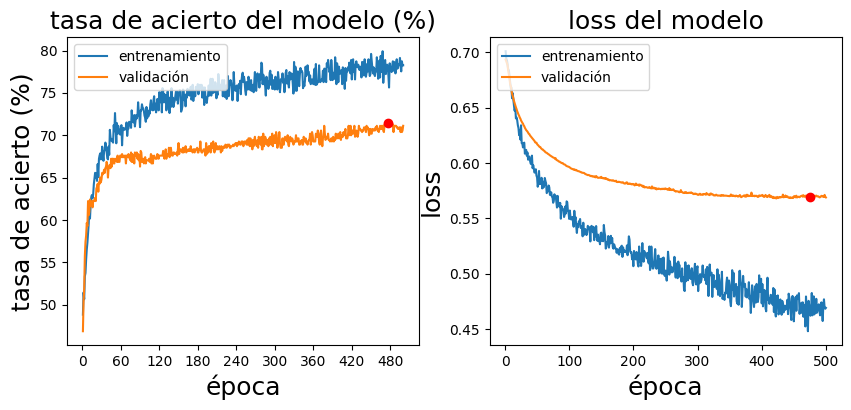

In [38]:
for e in range(epochs):
    history = model.fit(X_tr, y_tr, epochs=1, batch_size=32, callbacks=callbacks_list,
                        verbose=10, validation_data=(X_val,y_val))

    serie_tr_acc.append(history.history['accuracy'][0])
    serie_val_acc.append(history.history['val_accuracy'][0])
    serie_tr_loss.append(history.history['loss'][0])
    serie_val_loss.append(history.history['val_loss'][0])

    if len(serie_tr_acc) % 2 == 0:
        clear_output()
    grafica_entrenamiento(serie_tr_acc, serie_val_acc, serie_tr_loss, serie_val_loss)

Recupero el mejor modelo (punto rojo), que está grabado en el fichero dado por la variable modelpath:

In [39]:
modelpath

'best_model.keras'

In [40]:
from keras.models import load_model

model = load_model(modelpath)

## **Análisis de los resultados del modelo**

In [41]:
probs_predicciones_test = model.predict(X_test).flatten()
probs_predicciones_test[:5]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


array([0.14517824, 0.32377404, 0.95726585, 0.3913917 , 0.4461493 ],
      dtype=float32)

**Score (tasa de acierto, "accuracy") en test:**

In [42]:
predicciones_test = np.round(probs_predicciones_test)

np.mean(y_test == predicciones_test)

np.float64(0.735)

Score en training:

In [43]:
np.mean(y_tr == np.round(model.predict(X_tr).flatten()))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


np.float64(0.8214285714285714)

Score en validación:

In [44]:
np.mean(y_val == np.round(model.predict(X_val).flatten()))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


np.float64(0.7148148148148148)

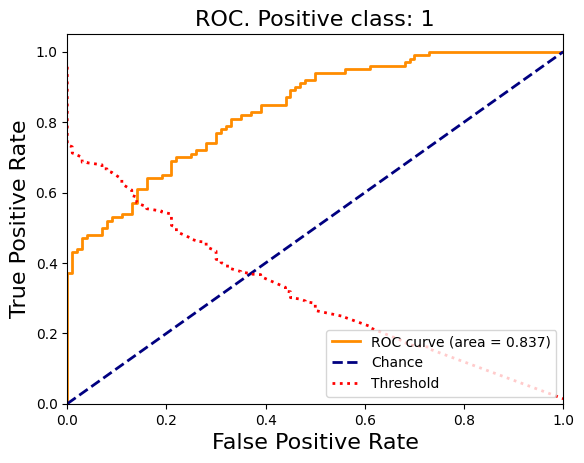

In [45]:
analisis_roc(y=y_test, positive_class_scores=probs_predicciones_test, POSITIVE_CLASS=1)

Confusion matrix, without normalization
[[78 22]
 [31 69]]


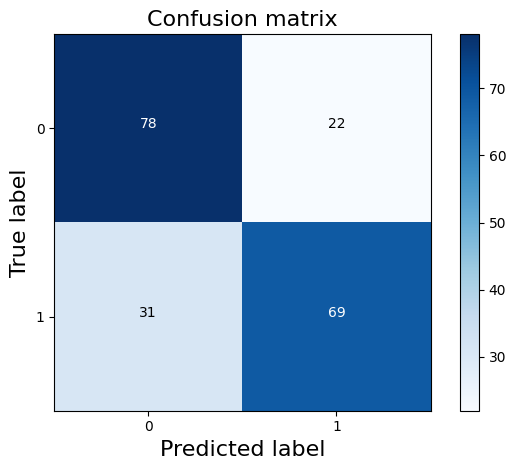

In [46]:
plot_confusion_matrix(y=y_test, y_pred=predicciones_test)